
# eBay Auctions (May–June 2004): EDA & Classification Trees

**Objective**: Predict whether an auction will be **competitive** (i.e., it receives at least two bids) using item, seller, and auction-setting features.


## Dataset & Variables

**File**: `ebayAuctions.xlsx` → **Sheet**: `eBay auctions`  
**Rows**: `1972` &nbsp;&nbsp; **Columns**: `8`

**Columns** (original):
- `Category` *(categorical)*: auction category (18 levels).
- `Currency` *(categorical)*: listing currency (`US`, `EUR`, `GBP`).
- `sellerRating` *(numeric)*: seller's eBay rating (non-negative integer, heavy-tailed).
- `Duration` *(numeric / discrete)*: length of auction in days (e.g., 1, 3, 5, 7, 10).
- `endDay` *(categorical)*: day of week the auction ends.
- `ClosePrice` *(numeric)*: final price at close (observed **after** auction).
- `OpenPrice` *(numeric)*: opening price set by seller.
- `Competitive?` *(binary 0/1)* → renamed to `Competitive`.

**Target**: `Competitive` (1 = competitive, 0 = non-competitive).


## Setup

In [1]:
DATA_PATH = "../Data/ebayAuctions.xlsx"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree, export_text
from sklearn.metrics import confusion_matrix, classification_report

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
sns.set_theme(context="notebook", style="whitegrid")

RANDOM_STATE = 42

## Load data & initial checks

In [2]:
df = pd.read_excel(DATA_PATH, sheet_name="eBay auctions").rename(columns={"Competitive?":"Competitive"})

# Quick overview
display(df.head())
print("\nShape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

# Basic sanity checks
print("\nMissing values:")
print(df.isna().sum())


,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0



Shape: (1972, 8)

Dtypes:
Category         object
Currency         object
sellerRating      int64
Duration          int64
endDay           object
ClosePrice      float64
OpenPrice       float64
Competitive       int64
dtype: object

Missing values:
Category        0
Currency        0
sellerRating    0
Duration        0
endDay          0
ClosePrice      0
OpenPrice       0
Competitive     0
dtype: int64



## Task 1 — EDA & Data Preparation (with reasoning)

We aim to:  
1. **Understand distributions** (skewness/heavy tails).  
2. **Detect outliers** (IQR rule & visual checks).  
3. **Decide transformations** (e.g., `log1p` for highly skewed prices/ratings).  
4. **Create dummy variables** for categorical predictors (needed for KNN/tree later).  
5. **Consider dropping** variables that are **not** useful or not available **before** the auction (for the practical model).  
6. Use **seaborn** to visualize relationships with `Competitive` for interpretability.


### 1) Univariate distributions

,OpenPrice,ClosePrice,sellerRating
count,1972.000000,1972.000000,1972.000000
mean,12.926268,36.449087,3560.238337
std,38.856149,89.493858,5973.011033
min,0.010000,0.010000,0.000000
25%,1.230000,4.907500,595.000000
50%,4.500000,9.995000,1853.000000
75%,9.990000,28.000000,3380.000000
max,999.000000,999.000000,37727.000000


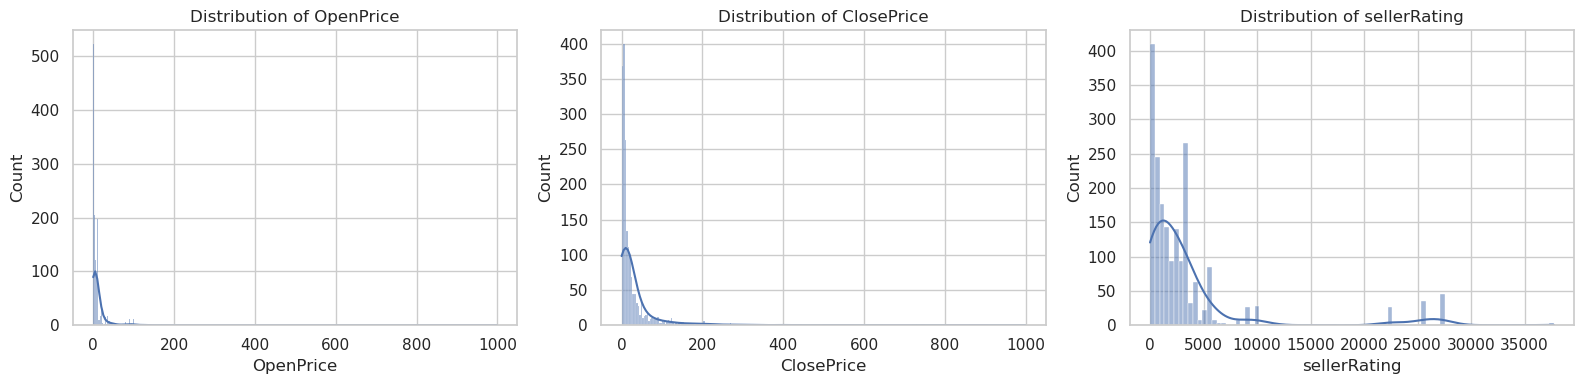

In [3]:
num_cols = ["OpenPrice", "ClosePrice", "sellerRating"]
cat_cols = ["Category", "Currency", "endDay", "Duration"]

# Stats
display(df[num_cols].describe())

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for ax, c in zip(axes, num_cols):
    sns.histplot(data=df, x=c, kde=True, ax=ax)
    ax.set_title(f"Distribution of {c}")
plt.tight_layout()
plt.show()

### 2) Outlier detection (IQR) & interpretation

In [4]:
def iqr_bounds(s: pd.Series):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

outlier_summary = []
for c in num_cols:
    low, high = iqr_bounds(df[c])
    mask = (df[c] < low) | (df[c] > high)
    outlier_summary.append({
        "feature": c, "low": low, "high": high,
        "outliers": int(mask.sum()),
        "pct_outliers": float(mask.mean()*100)
    })
outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

,feature,low,high,outliers,pct_outliers
0,OpenPrice,-11.91000,23.13000,206,10.446247
1,ClosePrice,-29.73125,62.63875,250,12.677485
2,sellerRating,-3582.50000,7557.50000,181,9.178499


Many 'outliers' appear due to heavy right-skew (e.g., prices up to 999). These are plausible rather than data errors → better handled by monotonic transformations than deletion.

### 3) Transformations (log1p) for skewness & stability

,OpenPrice,log_OpenPrice,ClosePrice,log_ClosePrice,sellerRating,log_sellerRating
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,12.926268,1.798731,36.449087,2.627458,3560.238337,7.142451
std,38.856149,1.127811,89.493858,1.267717,5973.011033,1.718672
min,0.010000,0.009950,0.010000,0.009950,0.000000,0.000000
25%,1.230000,0.802002,4.907500,1.776222,595.000000,6.390241
50%,4.500000,1.704748,9.995000,2.397441,1853.000000,7.525101
75%,9.990000,2.396986,28.000000,3.367296,3380.000000,8.125927
max,999.000000,6.907755,999.000000,6.907755,37727.000000,10.538158


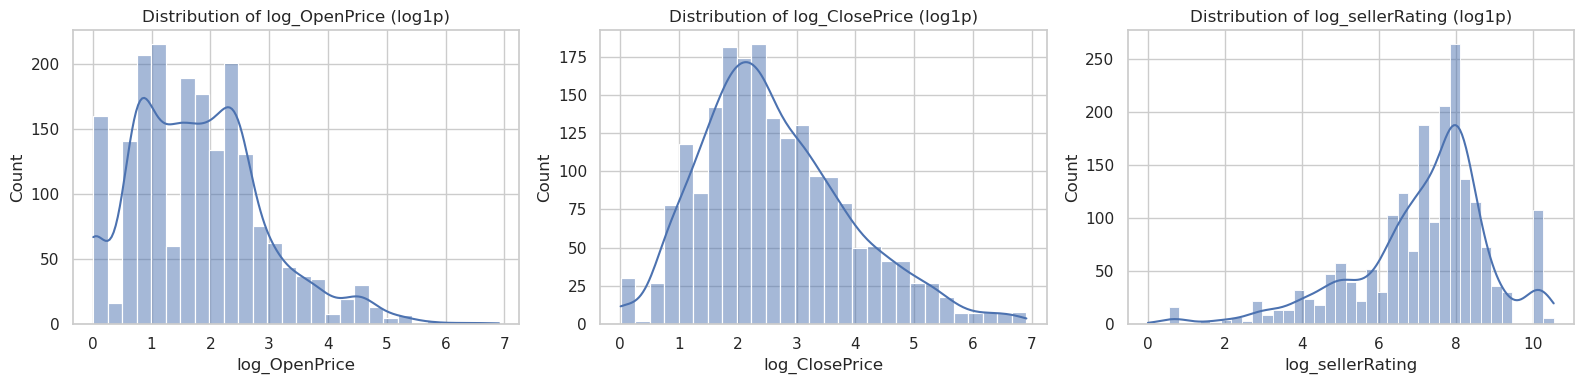

In [5]:
# Create transformed versions; keep original for interpretability.
df["log_OpenPrice"] = np.log1p(df["OpenPrice"])
df["log_ClosePrice"] = np.log1p(df["ClosePrice"])
df["log_sellerRating"] = np.log1p(df["sellerRating"])

display(df[["OpenPrice","log_OpenPrice","ClosePrice","log_ClosePrice","sellerRating","log_sellerRating"]].describe())

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for ax, c in zip(axes, ["log_OpenPrice", "log_ClosePrice", "log_sellerRating"]):
    sns.histplot(data=df, x=c, kde=True, ax=ax)
    ax.set_title(f"Distribution of {c} (log1p)")
plt.tight_layout()
plt.show()

log transforms compress heavy tails and make thresholds more stable for models like trees/KNN. We keep both raw and log forms for exploration; the practical tree can choose.

### 4) Bivariate relationships vs. `Competitive`

Competitive rate: 0.541


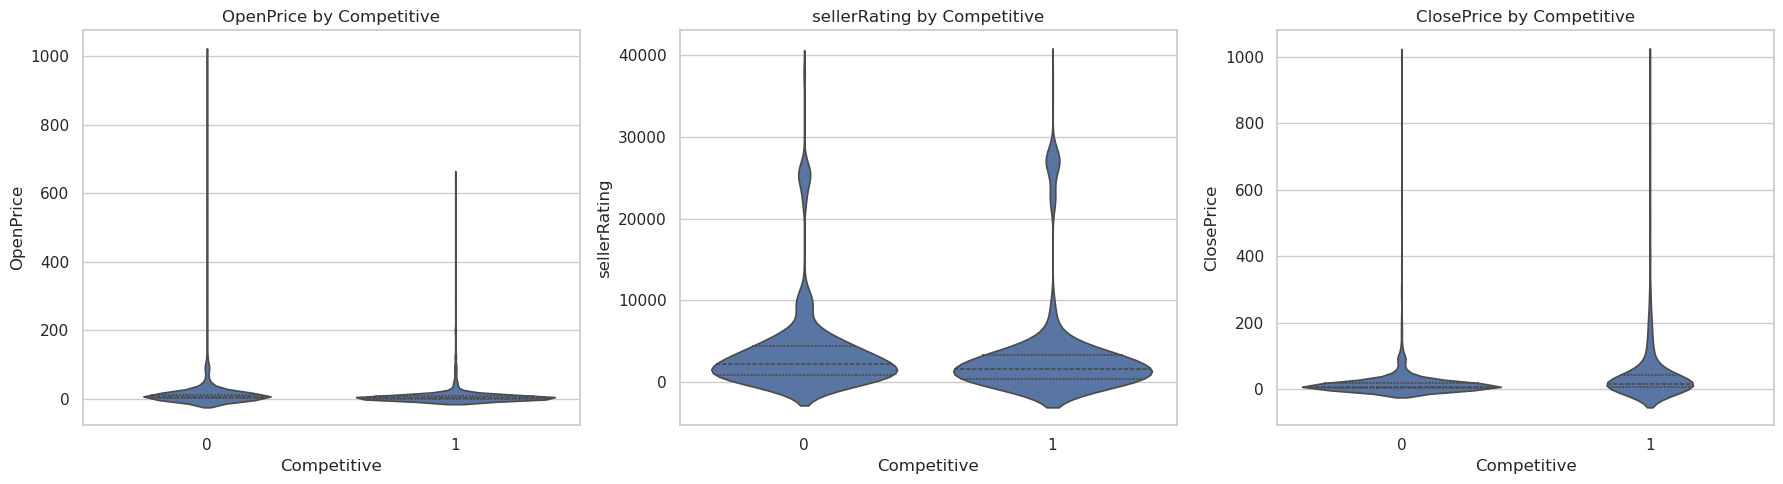

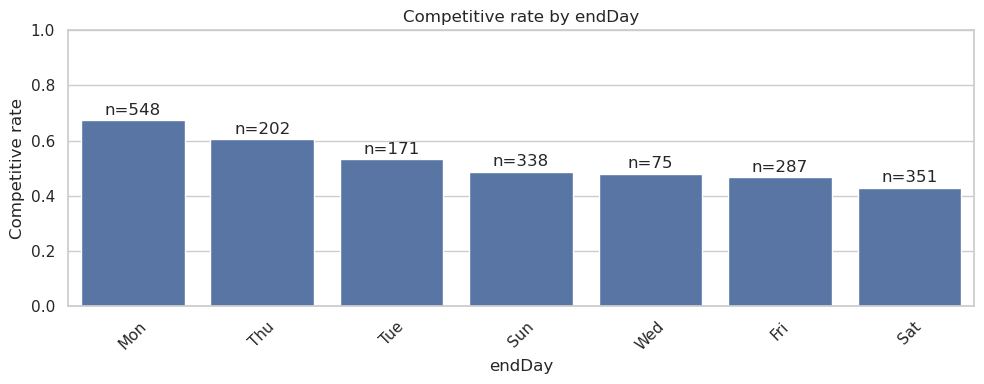

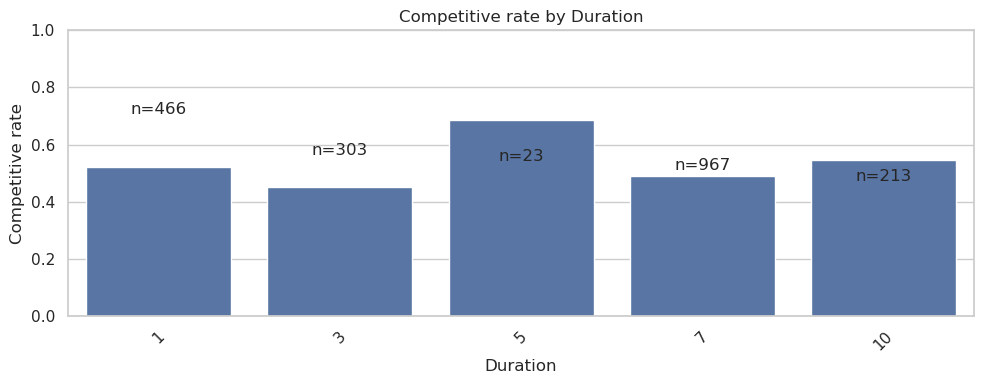

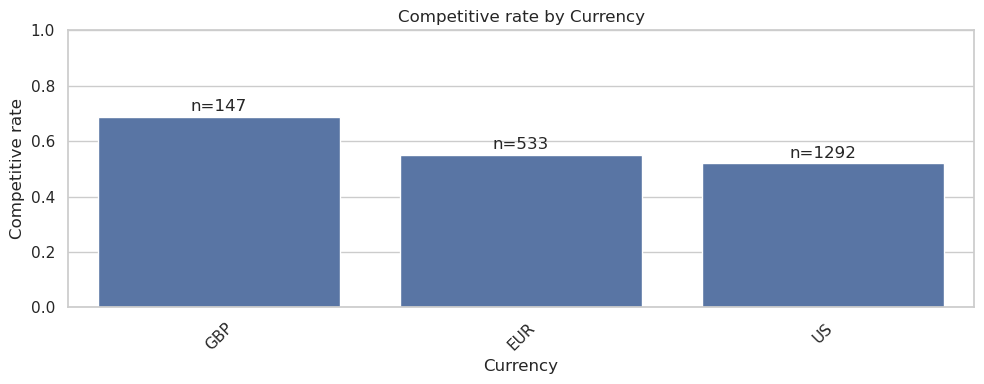

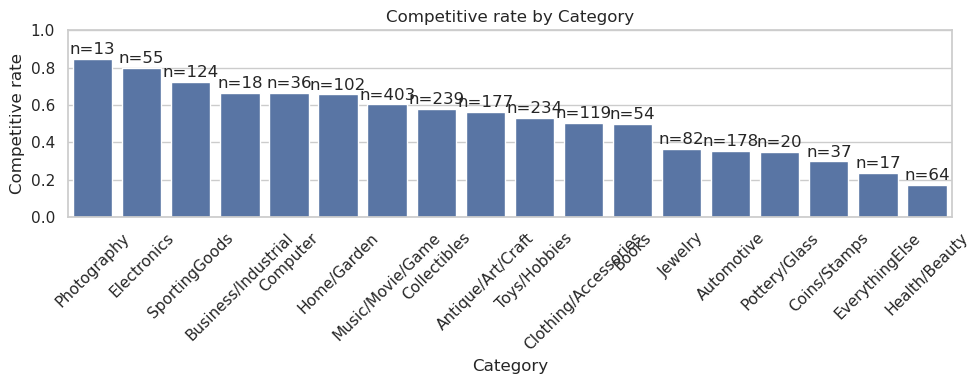

(  endDay      mean  count
 0    Mon  0.673358    548
 1    Thu  0.603960    202
 2    Tue  0.532164    171
 3    Sun  0.485207    338
 4    Wed  0.480000     75,
    Duration      mean  count
 0         5  0.686695    466
 1        10  0.544554    303
 2         1  0.521739     23
 3         7  0.489142    967
 4         3  0.450704    213,
   Currency      mean  count
 0      GBP  0.687075    147
 1      EUR  0.551595    533
 2       US  0.519350   1292)

In [6]:
# Competitive rate overall
print("Competitive rate:", df["Competitive"].mean().round(3))

# Numeric vs Competitive: violin with quartiles
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, c in zip(axes, ["OpenPrice","sellerRating","ClosePrice"]):
    sns.violinplot(data=df, x="Competitive", y=c, inner="quartile", ax=ax)
    ax.set_title(f"{c} by Competitive")
plt.tight_layout()
plt.show()

# Categorical vs Competitive: rates
def rate_barplot(col):
    tmp = (df.groupby(col)["Competitive"]
             .agg(["mean","count"])
             .sort_values("mean", ascending=False)
             .reset_index())
    plt.figure(figsize=(10,4))
    sns.barplot(data=tmp, x=col, y="mean")
    for i,row in tmp.iterrows():
        plt.text(i, row["mean"]+0.01, f"n={int(row['count'])}", ha="center", va="bottom", rotation=0)
    plt.ylabel("Competitive rate")
    plt.ylim(0,1)
    plt.title(f"Competitive rate by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return tmp

cat_rate_tables = {}
for col in ["endDay", "Duration", "Currency", "Category"]:
    cat_rate_tables[col] = rate_barplot(col)

cat_rate_tables["endDay"].head(), cat_rate_tables["Duration"].head(), cat_rate_tables["Currency"].head()

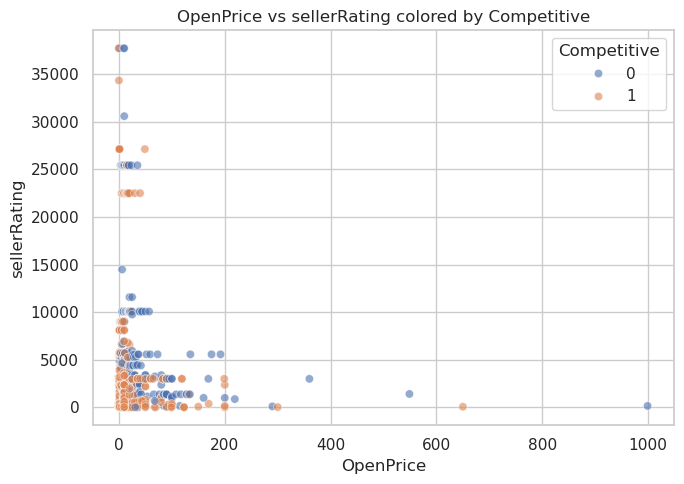

In [7]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="OpenPrice", y="sellerRating", hue="Competitive", alpha=0.6)
plt.title("OpenPrice vs sellerRating colored by Competitive")
plt.tight_layout()
plt.show()

### 5) Correlations among numeric features

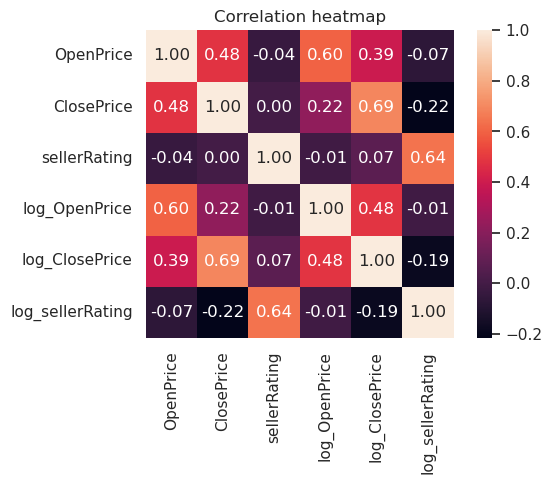

In [20]:
num_for_corr = ["OpenPrice","ClosePrice","sellerRating","log_OpenPrice","log_ClosePrice","log_sellerRating"]
corr = df[num_for_corr].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation heatmap")
plt.show()

### 6) Dummy variables for modeling

In [9]:

# We'll keep Duration as categorical (discrete day counts) for interpretability in trees & KNN.
cat_cols = ["Category","Currency","endDay","Duration"]
num_cols_base = ["sellerRating","OpenPrice","ClosePrice"]

df_model = df.copy()
X_full = pd.get_dummies(df_model[cat_cols + num_cols_base], drop_first=True)
y = df_model["Competitive"].astype(int)

print("X_full shape:", X_full.shape)
X_full.head()

X_full shape: (1972, 29)


,Duration,sellerRating,OpenPrice,ClosePrice,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,Category_Coins/Stamps,Category_Collectibles,Category_Computer,Category_Electronics,Category_EverythingElse,Category_Health/Beauty,Category_Home/Garden,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies,Currency_GBP,Currency_US,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
0,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
1,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
2,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
3,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
4,5,3249,0.01,0.01,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False



## Task 2 — Classification Tree(s)

### A) Full tree using **all predictors** (including `ClosePrice`)
> **Purpose**: Diagnostic/insight. Note `ClosePrice` is not known ahead of time, so this tree is **not** for practical prediction at listing time.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

tree_all = DecisionTreeClassifier(min_samples_leaf=50, random_state=RANDOM_STATE)
tree_all.fit(X_train, y_train)

y_pred = tree_all.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (All predictors):\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# Feature importances
imp = pd.Series(tree_all.feature_importances_, index=X_full.columns).sort_values(ascending=False)
imp.head(15)

Confusion matrix (All predictors):
 [[233  39]
 [ 64 256]]

Classification report:
               precision    recall  f1-score   support

           0      0.785     0.857     0.819       272
           1      0.868     0.800     0.833       320

    accuracy                          0.826       592
   macro avg      0.826     0.828     0.826       592
weighted avg      0.830     0.826     0.826       592



OpenPrice                        0.471948
ClosePrice                       0.445791
sellerRating                     0.082261
Duration                         0.000000
Category_Automotive              0.000000
Category_Books                   0.000000
Category_Business/Industrial     0.000000
Category_Clothing/Accessories    0.000000
Category_Coins/Stamps            0.000000
Category_Collectibles            0.000000
Category_Computer                0.000000
Category_Electronics             0.000000
Category_EverythingElse          0.000000
Category_Health/Beauty           0.000000
Category_Home/Garden             0.000000
dtype: float64

#### Summarize the resulting rules

In [11]:
def extract_rules(decision_tree, feature_names):
    tree_ = decision_tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # left
            left_path = path.copy()
            left_path.append(f"({name} <= {threshold:.2f})")
            recurse(tree_.children_left[node], left_path, paths)
            # right
            right_path = path.copy()
            right_path.append(f"({name} > {threshold:.2f})")
            recurse(tree_.children_right[node], right_path, paths)
        else:
            path_str = " AND ".join(path)
            value = tree_.value[node][0]
            pred = int(np.argmax(value))
            support = int(np.sum(value))
            paths.append((path_str, pred, support))

    recurse(0, path, paths)
    rules = pd.DataFrame(paths, columns=["Rule", "PredictedClass", "Support"]).sort_values("Support", ascending=False)
    return rules

rules_all = extract_rules(tree_all, X_full.columns)
rules_all.head(10)

,Rule,PredictedClass,Support
0,(OpenPrice <= 3.62) AND (ClosePrice <= 3.64) A...,1,1
1,(OpenPrice <= 3.62) AND (ClosePrice <= 3.64) A...,0,1
2,(OpenPrice <= 3.62) AND (ClosePrice <= 3.64) A...,1,1
3,(OpenPrice <= 3.62) AND (ClosePrice <= 3.64) A...,0,1
4,(OpenPrice <= 3.62) AND (ClosePrice > 3.64) AN...,1,1
5,(OpenPrice <= 3.62) AND (ClosePrice > 3.64) AN...,1,1
6,(OpenPrice > 3.62) AND (ClosePrice <= 10.00) A...,0,1
7,(OpenPrice > 3.62) AND (ClosePrice <= 10.00) A...,0,1
8,(OpenPrice > 3.62) AND (ClosePrice <= 10.00) A...,0,1
9,(OpenPrice > 3.62) AND (ClosePrice <= 10.00) A...,0,1


In [21]:
rules_all.Rule[1]

'(OpenPrice <= 3.62) AND (ClosePrice <= 3.64) AND (OpenPrice > 0.94) AND (ClosePrice <= 1.84)'

Look for thresholds on `OpenPrice`, `ClosePrice`, and `sellerRating` — these usually dominate.

#### Plot the tree (all predictors)

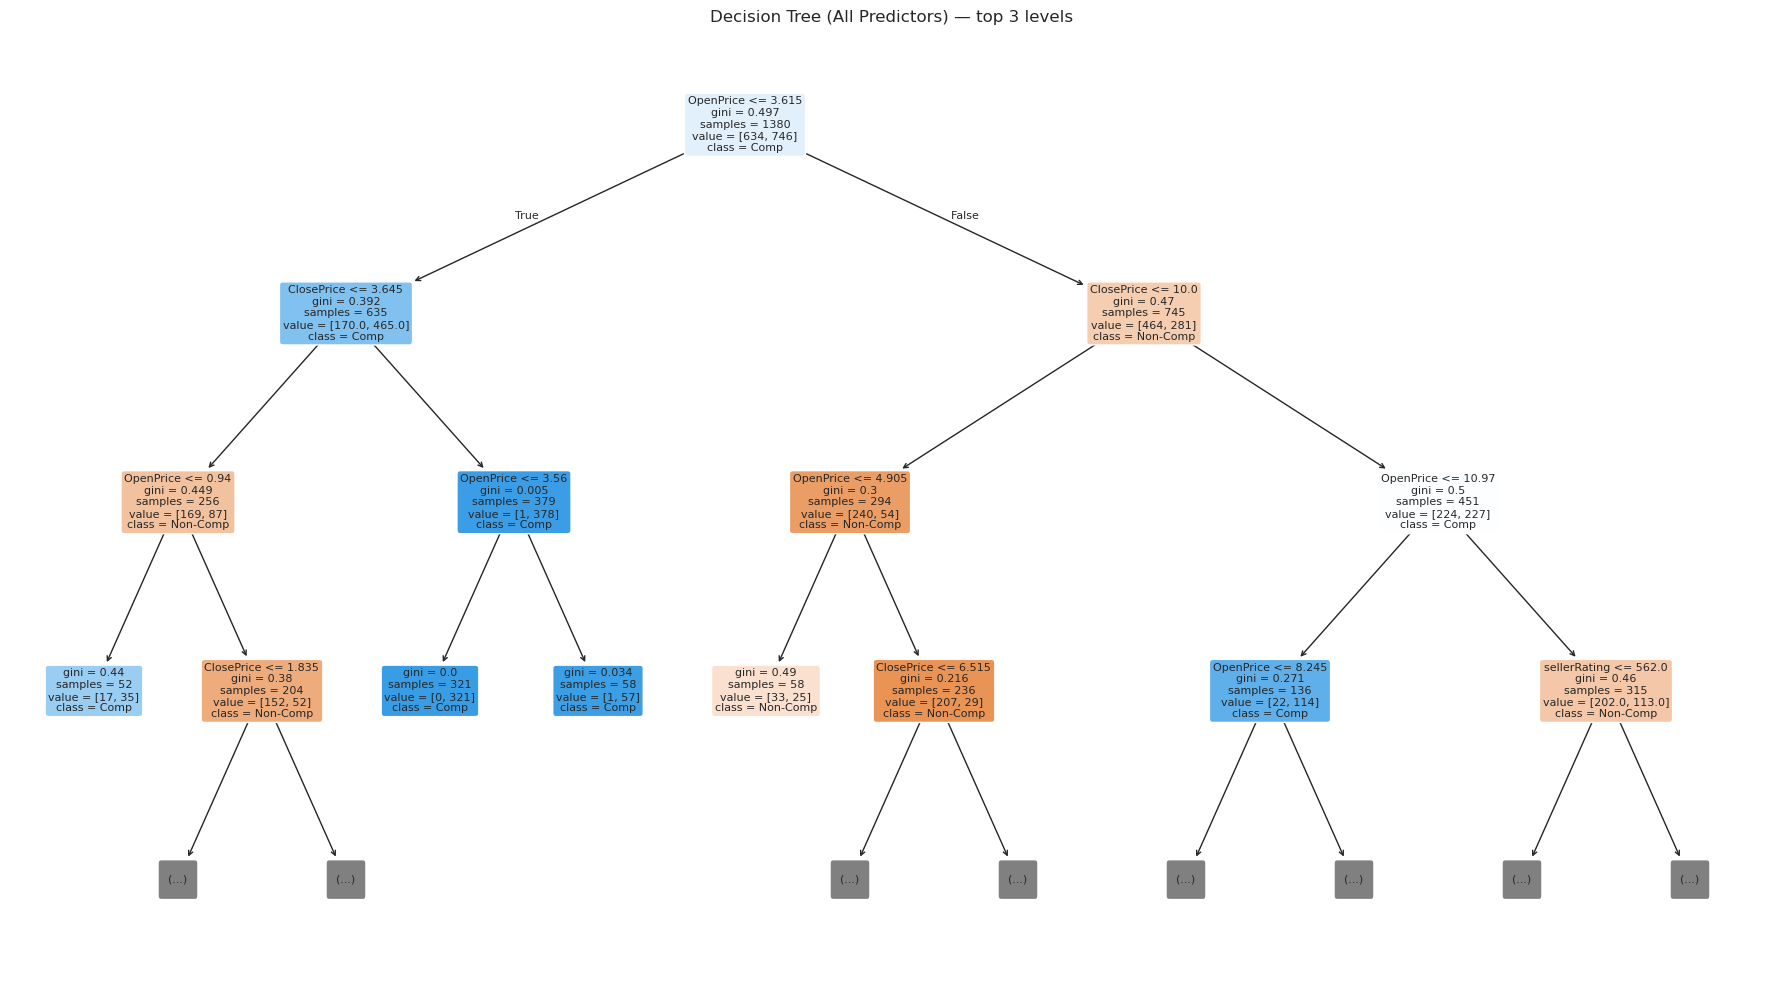

In [12]:
plt.figure(figsize=(18, 10))
plot_tree(tree_all, feature_names=X_full.columns, class_names=["Non-Comp","Comp"], filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (All Predictors) — top 3 levels")
plt.tight_layout()
plt.show()


### B) **Practical tree** (predictable at listing time only)

We drop **`ClosePrice`** and use only predictors that are available *before* the auction:  
- `OpenPrice`, `sellerRating`, `Category`, `Currency`, `Duration`, `endDay`.


In [13]:
usable_cols = ["Category","Currency","endDay","Duration","sellerRating","OpenPrice"]
X_use = pd.get_dummies(df_model[usable_cols], drop_first=True)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_use, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

tree_use = DecisionTreeClassifier(min_samples_leaf=50, random_state=RANDOM_STATE)
tree_use.fit(X_train2, y_train2)

y_pred2 = tree_use.predict(X_test2)
cm2 = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix (Usable predictors):\n", cm2)
print("\nClassification report:\n", classification_report(y_test2, y_pred2, digits=3))

imp2 = pd.Series(tree_use.feature_importances_, index=X_use.columns).sort_values(ascending=False)
imp2.head(15)

Confusion matrix (Usable predictors):
 [[192  80]
 [ 93 227]]

Classification report:
               precision    recall  f1-score   support

           0      0.674     0.706     0.689       272
           1      0.739     0.709     0.724       320

    accuracy                          0.708       592
   macro avg      0.707     0.708     0.707       592
weighted avg      0.709     0.708     0.708       592



OpenPrice                        0.573997
sellerRating                     0.312384
Duration                         0.082437
Category_Toys/Hobbies            0.020717
Currency_US                      0.005251
Category_Music/Movie/Game        0.005215
Category_Books                   0.000000
Category_Coins/Stamps            0.000000
Category_Collectibles            0.000000
Category_Business/Industrial     0.000000
Category_Clothing/Accessories    0.000000
Category_Automotive              0.000000
Category_EverythingElse          0.000000
Category_Electronics             0.000000
Category_Computer                0.000000
dtype: float64

#### Plot the tree (usable predictors)

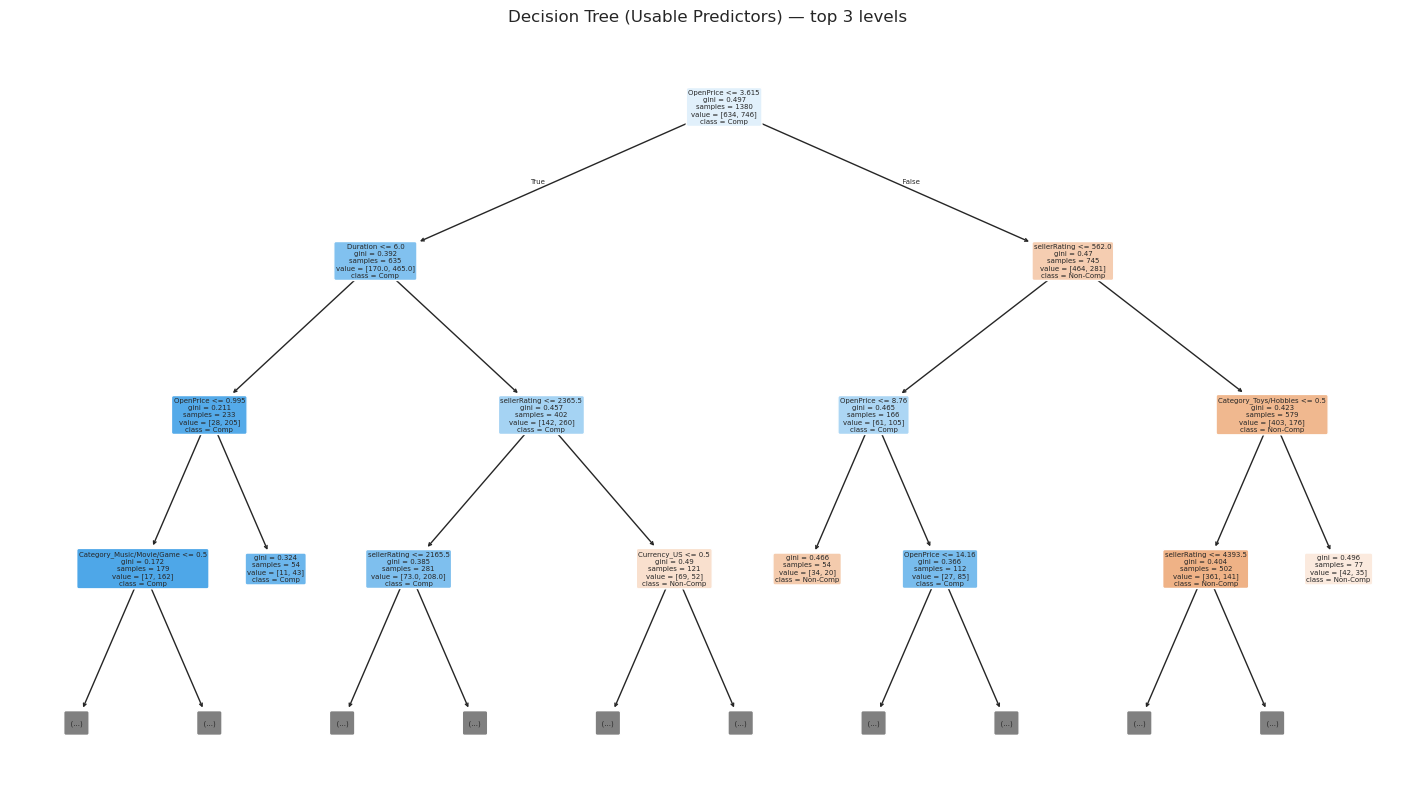

In [22]:
plt.figure(figsize=(18, 10))
plot_tree(tree_use, feature_names=X_use.columns, class_names=["Non-Comp","Comp"], filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (Usable Predictors) — top 3 levels")
plt.show()

#### Scatter plot with two best quantitative predictors & tree split lines

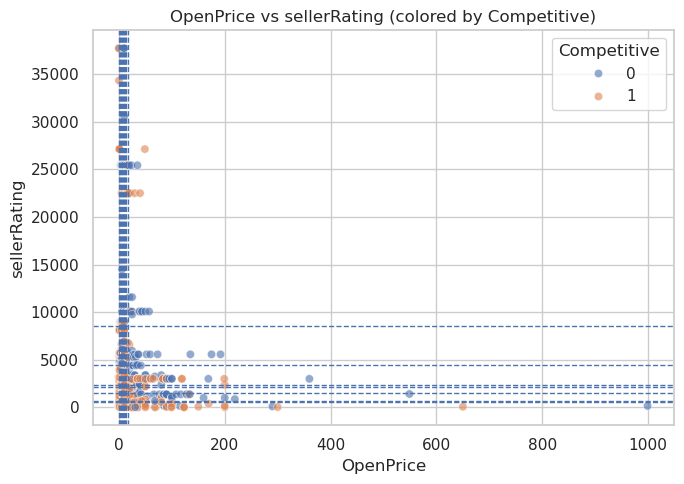

In [15]:
# Identify two best numeric predictors for the practical tree
two_numeric = ["OpenPrice","sellerRating"]  # typically dominate; easy to interpret

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="OpenPrice", y="sellerRating", hue="Competitive", alpha=0.6)
plt.title("OpenPrice vs sellerRating (colored by Competitive)")

# Extract split thresholds used by the practical tree on these two features
thresholds = []
tree_ = tree_use.tree_
feat_names = X_use.columns.tolist()
for node_idx in range(tree_.node_count):
    feat_idx = tree_.feature[node_idx]
    if feat_idx == _tree.TREE_UNDEFINED:
        continue
    feat_name = feat_names[feat_idx]
    thr = tree_.threshold[node_idx]
    # Only draw lines for the raw numeric columns (not dummies)
    if feat_name in two_numeric:
        thresholds.append((feat_name, thr))

# Draw unique thresholds
for name, thr in sorted(set(thresholds)):
    if name == "OpenPrice":
        plt.axvline(thr, linestyle="--", linewidth=1)
    elif name == "sellerRating":
        plt.axhline(thr, linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

Interpretation: Vertical (OpenPrice) and horizontal (sellerRating) dashed lines show decision splits. Lower OpenPrice thresholds often map to higher competitiveness; higher sellerRating thresholds help.

#### Rules (usable predictors)

In [16]:
rules_use = extract_rules(tree_use, X_use.columns)
rules_use.head(12)

,Rule,PredictedClass,Support
0,(OpenPrice <= 3.62) AND (Duration <= 6.00) AND...,1,1
1,(OpenPrice <= 3.62) AND (Duration <= 6.00) AND...,1,1
2,(OpenPrice <= 3.62) AND (Duration <= 6.00) AND...,1,1
3,(OpenPrice <= 3.62) AND (Duration > 6.00) AND ...,1,1
4,(OpenPrice <= 3.62) AND (Duration > 6.00) AND ...,1,1
5,(OpenPrice <= 3.62) AND (Duration > 6.00) AND ...,1,1
6,(OpenPrice <= 3.62) AND (Duration > 6.00) AND ...,1,1
7,(OpenPrice <= 3.62) AND (Duration > 6.00) AND ...,0,1
8,(OpenPrice <= 3.62) AND (Duration > 6.00) AND ...,0,1
9,(OpenPrice > 3.62) AND (sellerRating <= 562.00...,0,1


### C) Which predictors to keep if we must reduce dimensionality?

In [17]:
print("Top 10 importances (practical tree):")
imp2.head(10)

Top 10 importances (practical tree):


OpenPrice                       0.573997
sellerRating                    0.312384
Duration                        0.082437
Category_Toys/Hobbies           0.020717
Currency_US                     0.005251
Category_Music/Movie/Game       0.005215
Category_Books                  0.000000
Category_Coins/Stamps           0.000000
Category_Collectibles           0.000000
Category_Business/Industrial    0.000000
dtype: float64

Recommendation: Keep `OpenPrice` and `sellerRating` as the strongest quantitative drivers, optionally add `Duration` and `endDay` (coarse effects), and the strongest category dummies (if any).


## Conclusions & Recommendations

- **Obvious finding**: Lower **`OpenPrice`** strongly increases the chance of being competitive (it attracts initial bids).
- **Seller reputation** (`sellerRating`) matters: higher ratings associate with higher competitiveness, conditional on price.
- **Auction settings**:
  - **Duration**: 5-day auctions showed relatively higher competitive rates (in this sample), though 7- and 10-day also do fine.
  - **Ending day**: **Monday** and **Thursday** had higher competitive rates here than weekend endings; effects may be category-dependent.
  - **Currency**: GBP/EUR listings showed slightly higher rates in this sample; mix of categories and geographies likely contributes.
- **Categories**: Some categories (e.g., Photography, Electronics) show higher competitiveness in this sample, but sample sizes vary; use with caution.

**Practical guidance for sellers (from the practical tree):**
1. **Set a low opening price** to entice early bidding and momentum.  
2. **Leverage reputation**: maintain and display strong seller ratings; if new, consider strategies that build feedback first.  
3. **Choose duration wisely** (e.g., 5–7 days) and avoid low-activity end times; consider **Mon/Thu** endings (sample-specific).  
4. **Category nuances** exist — align price strategy with typical demand and competitor pricing.

> **Is the model practical?**  
> Yes, the **practical tree** (excluding `ClosePrice`) is simple to implement and interpret at listing time. Accuracy is lower than the full-information tree (as expected), but still helpful for decision support.

> **Classification table** is printed above for both trees. Prefer the practical tree for prediction at listing time.
